In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm  
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Custom imports ---
from helpers import load_dataset_paths, process_file, compute_average_signal, summarize_results_and_save
from featex import FeatureExtractor
from CNN_classifier import CNN1D

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0. Loading Preprocessed Files and Metadata

In [2]:
all_paths = load_dataset_paths()

# Example usage:
prima_files_BC_only = all_paths["PRIMA"]["BC_Only"]
prima_files_RGC_only = all_paths["PRIMA"]["RGC_Only"]
prima_files_BC_and_RGC = all_paths["PRIMA"]["BC_and_RGC"]

# print how many files are in each category
print(f"PRIMA BC_Only files: {len(prima_files_BC_only)}")
print(f"PRIMA RGC_Only files: {len(prima_files_RGC_only)}")
print(f"PRIMA BC_and_RGC files: {len(prima_files_BC_and_RGC)}")


# exclude SNR_summary_BC_and_RGC.csv from the list
prima_files_BC_and_RGC = [f for f in prima_files_BC_and_RGC if not f.endswith("SNR_summary_BC_and_RGC.csv")]
prima_files_RGC_only = [f for f in prima_files_RGC_only if not f.endswith("SNR_summary_RGC_Only.csv")]
prima_files_BC_only = [f for f in prima_files_BC_only if not f.endswith("SNR_summary_BC_Only.csv")]

PRIMA BC_Only files: 146
PRIMA RGC_Only files: 67
PRIMA BC_and_RGC files: 40


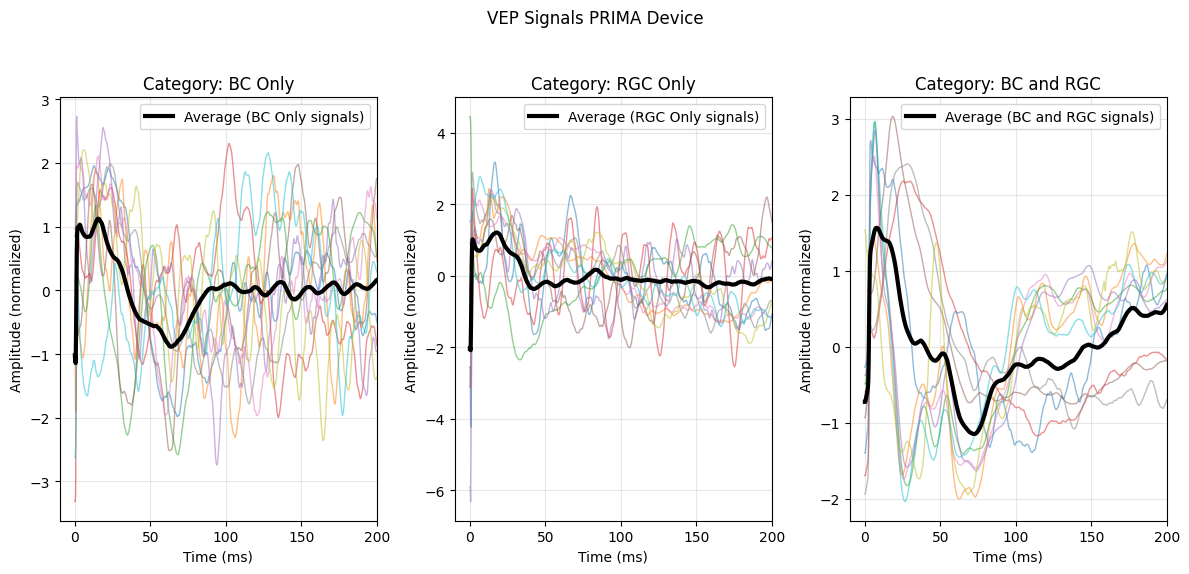

In [3]:

avg_BC_t, avg_BC_sig = compute_average_signal(prima_files_BC_only, t_min=0, t_max=200)
avg_RGC_t, avg_RGC_sig = compute_average_signal(prima_files_RGC_only, t_min=0, t_max=200)   
avg_BC_RGC_t, avg_BC_RGC_sig = compute_average_signal(prima_files_BC_and_RGC, t_min=0, t_max= 200)



example_files_BC = prima_files_BC_only[:10]
example_files_RGC = prima_files_RGC_only[:10]
example_files_BC_and_RGC = prima_files_BC_and_RGC[:10]

categories = [
    (example_files_BC, "BC Only", avg_BC_t, avg_BC_sig),
    (example_files_RGC, "RGC Only", avg_RGC_t, avg_RGC_sig),
    (example_files_BC_and_RGC, "BC and RGC", avg_BC_RGC_t, avg_BC_RGC_sig)
]

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.suptitle("VEP Signals PRIMA Device")
for i, (file_list, title, avg_t, avg_sig) in enumerate(categories, 1):
    plt.subplot(1, 3, i)

    # Plot some example signals
    for df in file_list: # 'df' is a DataFrame, NOT a file path
        # Use the helper function to extract, slice, and normalize the data
        time, signal = process_file(df, t_max=200, normalize=True)
        plt.plot(time, signal, alpha=0.5, lw=1)

    # Plot the class-wide average in black
    plt.plot(avg_t, avg_sig, color="k", lw=3, label=f"Average ({title} signals)")

    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (normalized)")
    plt.title(f"Category: {title}") # Added title for clarity
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim(-10, 200)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

## 2. DWT feature extraction

In [4]:
dwt_features, labels = [], []
for label in ["BC_Only", "RGC_Only", "BC_and_RGC"]:
    files = prima_files_BC_only if label == "BC_Only" else \
            prima_files_RGC_only if label == "RGC_Only" else \
            prima_files_BC_and_RGC

    for file in tqdm(files, desc=f"Extracting {label}"):
        _, signal = process_file(file, t_min=10, t_max=200)
        X_dwt = FeatureExtractor.extract_dwt_features(signal, wavelet='db4', level=4, max_length=100)
        dwt_features.append(X_dwt) 
        labels.append(label)

# Pad all to equal length (for CNN or ML)
max_len = max(len(f) for f in dwt_features)
dwt_features_padded = np.array([np.pad(f, (0, max_len - len(f))) for f in dwt_features])
labels = np.array(labels)


Extracting BC_and_RGC: 100%|██████████| 39/39 [00:00<00:00, 588.86it/s]


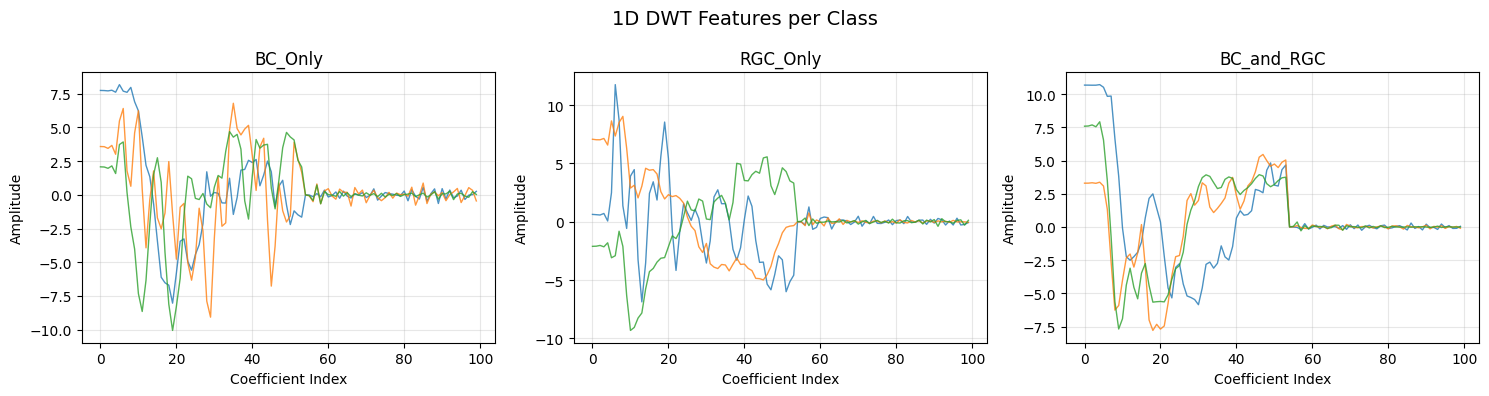

In [5]:
unique_labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]

# --- Plot 1D DWT features per class ---
plt.figure(figsize=(15, 4))
for i, label in enumerate(unique_labels, 1):
    plt.subplot(1, 3, i)
    
    # Get up to 3 examples from this class
    class_indices = np.where(labels == label)[0][:3]
    
    for idx in class_indices:
        plt.plot(dwt_features_padded[idx], lw=1, alpha=0.8)
    
    plt.title(f"{label}")
    plt.xlabel("Coefficient Index")
    plt.ylabel("Amplitude")
    plt.grid(alpha=0.3)

plt.suptitle("1D DWT Features per Class", fontsize=14)
plt.tight_layout()
plt.show()

## Classification


=== Processing Signal Type: Raw ===
--- Experiment 1 ---
Number of training samples: 117
Using batch size: 11
Using epochs: 35


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.4731 |     0.6667
    2 |     0.8602 |     0.5833
    3 |     0.9462 |     0.7500
    4 |     0.9785 |     0.6667
    5 |     0.9462 |     0.6667
    6 |     1.0000 |     0.6667
    7 |     0.9677 |     0.6250
    8 |     0.9892 |     0.6250
    9 |     1.0000 |     0.6250
   10 |     1.0000 |     0.5417
   11 |     0.9892 |     0.5417
   12 |     1.0000 |     0.5417
   13 |     1.0000 |     0.5417
   14 |     0.9785 |     0.5417
   15 |     1.0000 |     0.5417
   16 |     0.9892 |     0.5417
   17 |     0.9892 |     0.5417
   18 |     0.9892 |     0.5417
   19 |     0.9892 |     0.5000
   20 |     0.9892 |     0.5000
   21 |     0.9892 |     0.5417
   22 |     1.0000 |     0.5417
   23 |     1.0000 |     0.5417
   24 |     1.0000 |     0.5417
   25 |     1.0000 |     0.5417
   26 |     1.0000 |     0.5417
   27 |     1.0000 |     0.5417
   28 |     1.0000 |     0.5417
   29 |     1.0000 |     0.5833
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(93, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(186, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.ve

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5484 |     0.5000
    2 |     0.8817 |     0.6250
    3 |     0.9140 |     0.6667
    4 |     0.9355 |     0.5417
    5 |     0.9570 |     0.4583
    6 |     0.9462 |     0.4583
    7 |     0.9892 |     0.4583
    8 |     1.0000 |     0.5000
    9 |     0.9677 |     0.5000
   10 |     0.9785 |     0.5000
   11 |     1.0000 |     0.5000
   12 |     0.9892 |     0.5000
   13 |     1.0000 |     0.4583
   14 |     0.9785 |     0.4167
   15 |     1.0000 |     0.4167
   16 |     0.9892 |     0.4583
   17 |     1.0000 |     0.5417
   18 |     0.9892 |     0.5000
   19 |     0.9892 |     0.4583
   20 |     0.9892 |     0.4167
   21 |     1.0000 |     0.4583
   22 |     1.0000 |     0.4583
   23 |     1.0000 |     0.4583
   24 |     1.0000 |     0.4583
   25 |     1.0000 |     0.4583
   26 |     1.0000 |     0.4583
   27 |     1.0000 |     0.4583
   28 |     0.9892 |     0.5000
   29 |     1.0000 |     0.4583
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=['Tensor(shape=(93, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=['Tensor(shape=(186, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5957 |     0.3913
    2 |     0.7766 |     0.4348
    3 |     0.8936 |     0.5217
    4 |     0.9149 |     0.6957
    5 |     0.9787 |     0.5652
    6 |     0.9681 |     0.6087
    7 |     0.9787 |     0.6087
    8 |     0.9787 |     0.6087
    9 |     0.9787 |     0.6522
   10 |     1.0000 |     0.6522
   11 |     0.9894 |     0.6522
   12 |     0.9894 |     0.6522
   13 |     1.0000 |     0.6522
   14 |     0.9894 |     0.6522
   15 |     1.0000 |     0.6522
   16 |     1.0000 |     0.6522
   17 |     1.0000 |     0.6522
   18 |     1.0000 |     0.6522
   19 |     1.0000 |     0.6522
   20 |     1.0000 |     0.6522
   21 |     1.0000 |     0.6522
   22 |     1.0000 |     0.6522
   23 |     1.0000 |     0.6522
   24 |     1.0000 |     0.6522
   25 |     1.0000 |     0.6522
   26 |     1.0000 |     0.6522
   27 |     1.0000 |     0.6522
   28 |     1.0000 |     0.6522
   29 |     1.0000 |     0.6522
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_22
Received: inputs=['Tensor(shape=(94, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_22
Received: inputs=['Tensor(shape=(188, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.4894 |     0.5217
    2 |     0.8191 |     0.6522
    3 |     0.8723 |     0.6957
    4 |     0.9574 |     0.7391
    5 |     0.9681 |     0.6957
    6 |     1.0000 |     0.6957
    7 |     1.0000 |     0.6522
    8 |     0.9787 |     0.6957
    9 |     0.9894 |     0.6957
   10 |     1.0000 |     0.6522
   11 |     0.9787 |     0.6522
   12 |     1.0000 |     0.6522
   13 |     1.0000 |     0.6957
   14 |     1.0000 |     0.6957
   15 |     0.9894 |     0.6957
   16 |     1.0000 |     0.6087
   17 |     0.9787 |     0.5652
   18 |     0.9894 |     0.5652
   19 |     0.9894 |     0.5652
   20 |     1.0000 |     0.6522
   21 |     0.9894 |     0.6522
   22 |     1.0000 |     0.6522
   23 |     1.0000 |     0.6522
   24 |     1.0000 |     0.6522
   25 |     1.0000 |     0.6522
   26 |     0.9894 |     0.6522
   27 |     1.0000 |     0.6522
   28 |     0.9894 |     0.6522
   29 |     1.0000 |     0.6522
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_33
Received: inputs=['Tensor(shape=(94, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_33
Received: inputs=['Tensor(shape=(188, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5000 |     0.6087
    2 |     0.7766 |     0.6087
    3 |     0.8830 |     0.7391
    4 |     0.9362 |     0.7826
    5 |     0.9574 |     0.7391
    6 |     0.9574 |     0.7391
    7 |     0.9787 |     0.6522
    8 |     0.9681 |     0.7391
    9 |     1.0000 |     0.7826
   10 |     0.9787 |     0.6957
   11 |     0.9894 |     0.6957
   12 |     0.9894 |     0.6957
   13 |     1.0000 |     0.6522
   14 |     1.0000 |     0.6522
   15 |     0.9894 |     0.6522
   16 |     0.9894 |     0.6957
   17 |     0.9894 |     0.6957
   18 |     0.9894 |     0.6522
   19 |     0.9787 |     0.6087
   20 |     1.0000 |     0.6087
   21 |     0.9681 |     0.6087
   22 |     0.9894 |     0.6087
   23 |     0.9787 |     0.6522
   24 |     1.0000 |     0.6957
   25 |     0.9894 |     0.6957
   26 |     0.9894 |     0.6957
   27 |     0.9894 |     0.6957
   28 |     0.9894 |     0.6522
   29 |     1.0000 |     0.6087
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_44
Received: inputs=['Tensor(shape=(94, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_44
Received: inputs=['Tensor(shape=(188, 801, 1))']
  warnings.warn(msg)


shap_results_shapes: (23, 801, 1, 3)
mean_shap shape: (801,)
mean_shap shape: (801,)
mean_shap shape: (801,)


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_44
Received: inputs=['Tensor(shape=(23, 801, 1))']
  warnings.warn(msg)


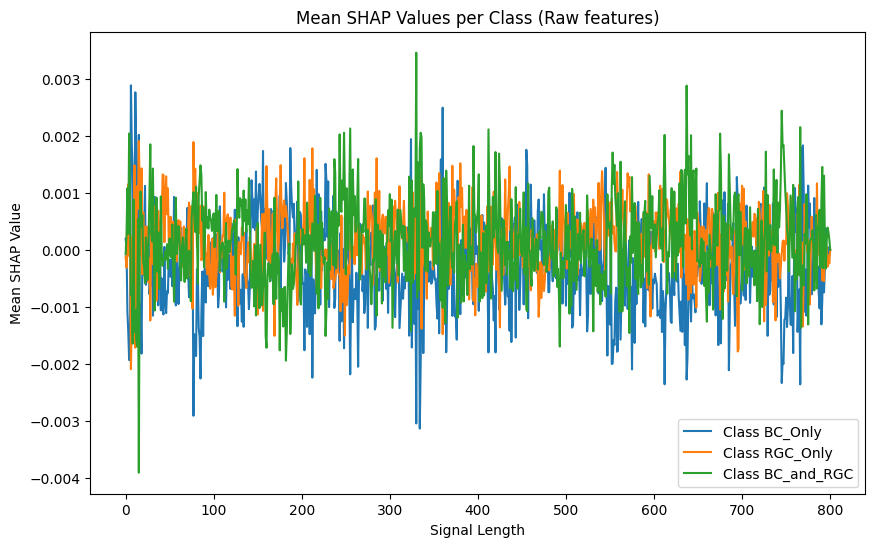

[[11 14 14]
 [ 5 28  6]
 [ 0  1 38]]
--- Experiment 2 ---
Number of training samples: 117
Using batch size: 11
Using epochs: 35


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.3871 |     0.6250
    2 |     0.8172 |     0.6667
    3 |     0.9032 |     0.7917
    4 |     0.9355 |     0.7500
    5 |     0.9677 |     0.6250
    6 |     0.9677 |     0.6250
    7 |     0.9892 |     0.7500
    8 |     0.9892 |     0.7500
    9 |     0.9785 |     0.7500
   10 |     0.9892 |     0.7083
   11 |     0.9785 |     0.7500
   12 |     1.0000 |     0.7083
   13 |     0.9785 |     0.7083
   14 |     1.0000 |     0.7500
   15 |     1.0000 |     0.7500
   16 |     1.0000 |     0.7500
   17 |     1.0000 |     0.7500
   18 |     1.0000 |     0.7500
   19 |     1.0000 |     0.7500
   20 |     1.0000 |     0.7500
   21 |     1.0000 |     0.7500
   22 |     0.9785 |     0.7917
   23 |     1.0000 |     0.7917
   24 |     1.0000 |     0.7917
   25 |     1.0000 |     0.7917
   26 |     0.9892 |     0.7917
   27 |     0.9892 |     0.7500
   28 |     1.0000 |     0.7500
   29 |     0.9892 |     0.8333
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_55
Received: inputs=['Tensor(shape=(93, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_55
Received: inputs=['Tensor(shape=(186, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.4839 |     0.5417
    2 |     0.8280 |     0.4167
    3 |     0.9032 |     0.5417
    4 |     0.9570 |     0.5417
    5 |     0.9247 |     0.5000
    6 |     0.9677 |     0.5417
    7 |     0.9677 |     0.5417
    8 |     1.0000 |     0.5417
    9 |     1.0000 |     0.5417
   10 |     1.0000 |     0.5417
   11 |     1.0000 |     0.5417
   12 |     1.0000 |     0.5417
   13 |     0.9892 |     0.5417
   14 |     1.0000 |     0.5417
   15 |     1.0000 |     0.4583
   16 |     0.9785 |     0.5417
   17 |     1.0000 |     0.5833
   18 |     0.9892 |     0.5833
   19 |     1.0000 |     0.5417
   20 |     0.9892 |     0.5417
   21 |     1.0000 |     0.5417
   22 |     0.9892 |     0.5417
   23 |     1.0000 |     0.5417
   24 |     0.9785 |     0.5417
   25 |     1.0000 |     0.5417
   26 |     1.0000 |     0.5417
   27 |     0.9892 |     0.5417
   28 |     0.9892 |     0.5417
   29 |     0.9892 |     0.5000
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_66
Received: inputs=['Tensor(shape=(93, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_66
Received: inputs=['Tensor(shape=(186, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5745 |     0.4348
    2 |     0.8723 |     0.5217
    3 |     0.9681 |     0.6087
    4 |     0.9894 |     0.5652
    5 |     0.9894 |     0.6087
    6 |     1.0000 |     0.5217
    7 |     1.0000 |     0.5217
    8 |     1.0000 |     0.5217
    9 |     1.0000 |     0.4783
   10 |     0.9894 |     0.4783
   11 |     0.9894 |     0.5217
   12 |     1.0000 |     0.4783
   13 |     1.0000 |     0.4783
   14 |     1.0000 |     0.4783
   15 |     0.9894 |     0.3478
   16 |     0.9894 |     0.4783
   17 |     1.0000 |     0.4783
   18 |     1.0000 |     0.4783
   19 |     0.9894 |     0.4783
   20 |     1.0000 |     0.4783
   21 |     1.0000 |     0.4783
   22 |     1.0000 |     0.4783
   23 |     1.0000 |     0.4783
   24 |     1.0000 |     0.4783
   25 |     1.0000 |     0.4783
   26 |     1.0000 |     0.4783
   27 |     1.0000 |     0.4783
   28 |     1.0000 |     0.4783
   29 |     1.0000 |     0.4783
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_77
Received: inputs=['Tensor(shape=(94, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_77
Received: inputs=['Tensor(shape=(188, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.4681 |     0.4783
    2 |     0.8085 |     0.5652
    3 |     0.8404 |     0.5652
    4 |     0.9043 |     0.6087
    5 |     0.9468 |     0.6522
    6 |     0.9574 |     0.6087
    7 |     0.9468 |     0.6087
    8 |     1.0000 |     0.5652
    9 |     0.9787 |     0.5652
   10 |     0.9894 |     0.5217
   11 |     1.0000 |     0.5217
   12 |     1.0000 |     0.5652
   13 |     0.9681 |     0.6522
   14 |     0.9787 |     0.6087
   15 |     1.0000 |     0.5652
   16 |     0.9894 |     0.5217
   17 |     0.9681 |     0.5652
   18 |     1.0000 |     0.5217
   19 |     0.9894 |     0.5217
   20 |     0.9787 |     0.6522
   21 |     0.9894 |     0.6087
   22 |     0.9894 |     0.6087
   23 |     0.9894 |     0.5652
   24 |     1.0000 |     0.5652
   25 |     0.9894 |     0.6522
   26 |     0.9894 |     0.6522
   27 |     1.0000 |     0.6522
   28 |     0.9894 |     0.6522
   29 |     1.0000 |     0.6522
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_88
Received: inputs=['Tensor(shape=(94, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_88
Received: inputs=['Tensor(shape=(188, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.4468 |     0.5652
    2 |     0.8511 |     0.5652
    3 |     0.8830 |     0.6522
    4 |     0.9255 |     0.6522
    5 |     0.8936 |     0.6957
    6 |     0.9681 |     0.6522
    7 |     0.9787 |     0.6087
    8 |     0.9787 |     0.5652
    9 |     0.9787 |     0.6087
   10 |     1.0000 |     0.5652
   11 |     1.0000 |     0.5652
   12 |     0.9574 |     0.6087
   13 |     0.9787 |     0.6087
   14 |     1.0000 |     0.6087
   15 |     1.0000 |     0.6087
   16 |     1.0000 |     0.6087
   17 |     0.9894 |     0.6087
   18 |     0.9787 |     0.5652
   19 |     1.0000 |     0.4783
   20 |     0.9894 |     0.4783
   21 |     0.9787 |     0.5217
   22 |     0.9787 |     0.5217
   23 |     0.9894 |     0.6087
   24 |     0.9681 |     0.5652
   25 |     0.9894 |     0.5217
   26 |     1.0000 |     0.5217
   27 |     0.9894 |     0.6087
   28 |     0.9894 |     0.6522
   29 |     1.0000 |     0.6522
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_99
Received: inputs=['Tensor(shape=(94, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_99
Received: inputs=['Tensor(shape=(188, 801, 1))']
  warnings.warn(msg)


shap_results_shapes: (23, 801, 1, 3)
mean_shap shape: (801,)
mean_shap shape: (801,)
mean_shap shape: (801,)


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_99
Received: inputs=['Tensor(shape=(23, 801, 1))']
  warnings.warn(msg)


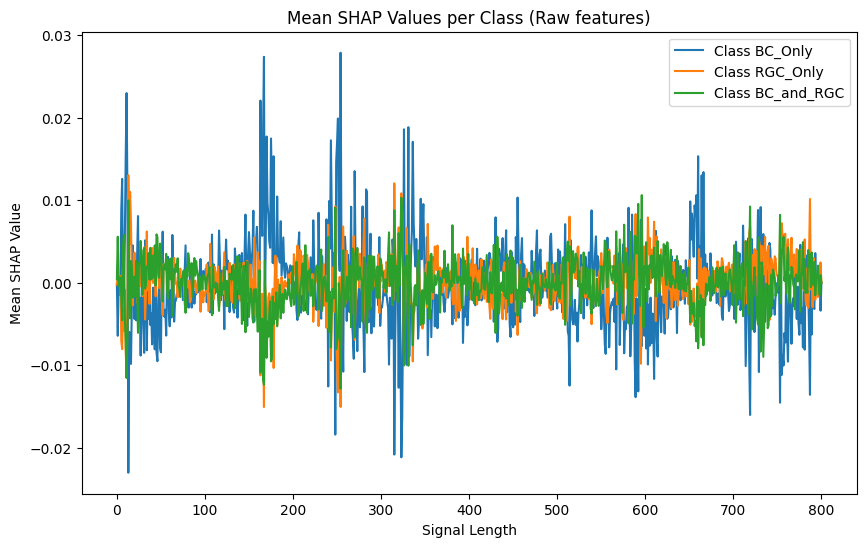

[[13 17  9]
 [ 9 26  4]
 [ 0  1 38]]
--- Experiment 3 ---
Number of training samples: 117
Using batch size: 11
Using epochs: 35


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.3978 |     0.5000
    2 |     0.7742 |     0.6667
    3 |     0.9032 |     0.7083
    4 |     0.9570 |     0.7500
    5 |     0.9785 |     0.7917
    6 |     0.9677 |     0.8333
    7 |     0.9892 |     0.7917
    8 |     0.9570 |     0.7917
    9 |     0.9892 |     0.7500
   10 |     0.9892 |     0.7500
   11 |     1.0000 |     0.7500
   12 |     0.9785 |     0.7500
   13 |     0.9785 |     0.7917
   14 |     0.9892 |     0.7500
   15 |     1.0000 |     0.7500
   16 |     0.9892 |     0.7500
   17 |     1.0000 |     0.7083
   18 |     0.9785 |     0.7917
   19 |     1.0000 |     0.7917
   20 |     1.0000 |     0.7917
   21 |     0.9892 |     0.7500
   22 |     1.0000 |     0.7500
   23 |     0.9892 |     0.7500
   24 |     1.0000 |     0.7500
   25 |     0.9892 |     0.7917
   26 |     0.9892 |     0.7917
   27 |     0.9892 |     0.7917
   28 |     1.0000 |     0.7917
   29 |     0.9892 |     0.7917
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_110
Received: inputs=['Tensor(shape=(93, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_110
Received: inputs=['Tensor(shape=(186, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5376 |     0.3333
    2 |     0.8710 |     0.4583
    3 |     0.9355 |     0.4583
    4 |     0.9247 |     0.4583
    5 |     0.9785 |     0.5000
    6 |     0.9570 |     0.5000
    7 |     0.9462 |     0.4583
    8 |     1.0000 |     0.4167
    9 |     1.0000 |     0.4167
   10 |     0.9677 |     0.4167
   11 |     0.9892 |     0.4583
   12 |     0.9785 |     0.4583
   13 |     0.9785 |     0.4583
   14 |     0.9785 |     0.3750
   15 |     0.9677 |     0.4167
   16 |     0.9785 |     0.4167
   17 |     1.0000 |     0.4583
   18 |     0.9892 |     0.4167
   19 |     1.0000 |     0.4167
   20 |     0.9785 |     0.4167
   21 |     0.9892 |     0.4167
   22 |     1.0000 |     0.4167
   23 |     1.0000 |     0.4167
   24 |     0.9892 |     0.4583
   25 |     0.9785 |     0.4167
   26 |     1.0000 |     0.5000
   27 |     1.0000 |     0.5000
   28 |     1.0000 |     0.4583
   29 |     1.0000 |     0.4583
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_121
Received: inputs=['Tensor(shape=(93, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_121
Received: inputs=['Tensor(shape=(186, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5638 |     0.3478
    2 |     0.8936 |     0.3478
    3 |     0.9362 |     0.3478
    4 |     0.9574 |     0.4348
    5 |     0.9787 |     0.5652
    6 |     1.0000 |     0.5652
    7 |     1.0000 |     0.5652
    8 |     1.0000 |     0.5217
    9 |     0.9894 |     0.5652
   10 |     1.0000 |     0.6087
   11 |     1.0000 |     0.6087
   12 |     1.0000 |     0.6522
   13 |     1.0000 |     0.6087
   14 |     0.9894 |     0.6087
   15 |     0.9894 |     0.6087
   16 |     1.0000 |     0.5652
   17 |     1.0000 |     0.6087
   18 |     1.0000 |     0.5652
   19 |     1.0000 |     0.6087
   20 |     0.9894 |     0.5652
   21 |     0.9894 |     0.6522
   22 |     1.0000 |     0.6957
   23 |     1.0000 |     0.6957
   24 |     0.9787 |     0.6957
   25 |     1.0000 |     0.6087
   26 |     0.9787 |     0.5217
   27 |     0.9894 |     0.5652
   28 |     0.9894 |     0.5217
   29 |     1.0000 |     0.5217
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_132
Received: inputs=['Tensor(shape=(94, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_132
Received: inputs=['Tensor(shape=(188, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5213 |     0.3913
    2 |     0.8085 |     0.6522
    3 |     0.9043 |     0.6522
    4 |     0.9787 |     0.5652
    5 |     0.9255 |     0.5217
    6 |     0.9787 |     0.5217
    7 |     0.9574 |     0.5217
    8 |     0.9787 |     0.4348
    9 |     0.9681 |     0.5217
   10 |     0.9787 |     0.5217
   11 |     1.0000 |     0.5217
   12 |     0.9894 |     0.5217
   13 |     0.9894 |     0.5217
   14 |     0.9681 |     0.5217
   15 |     1.0000 |     0.5652
   16 |     0.9894 |     0.6522
   17 |     1.0000 |     0.6522
   18 |     1.0000 |     0.6087
   19 |     1.0000 |     0.6087
   20 |     1.0000 |     0.6522
   21 |     0.9787 |     0.6522
   22 |     1.0000 |     0.6522
   23 |     1.0000 |     0.6522
   24 |     1.0000 |     0.6522
   25 |     1.0000 |     0.6522
   26 |     1.0000 |     0.6522
   27 |     1.0000 |     0.6522
   28 |     1.0000 |     0.6522
   29 |     0.9894 |     0.6522
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_143
Received: inputs=['Tensor(shape=(94, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_143
Received: inputs=['Tensor(shape=(188, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5957 |     0.3478
    2 |     0.7872 |     0.5217
    3 |     0.9043 |     0.6957
    4 |     0.9468 |     0.7391
    5 |     0.9362 |     0.6957
    6 |     0.9681 |     0.6957
    7 |     0.9894 |     0.6522
    8 |     1.0000 |     0.6957
    9 |     0.9894 |     0.6522
   10 |     0.9894 |     0.5652
   11 |     1.0000 |     0.5652
   12 |     0.9894 |     0.6087
   13 |     0.9894 |     0.5652
   14 |     0.9894 |     0.5217
   15 |     0.9787 |     0.5652
   16 |     1.0000 |     0.5652
   17 |     1.0000 |     0.5652
   18 |     0.9894 |     0.5217
   19 |     0.9894 |     0.5217
   20 |     1.0000 |     0.5217
   21 |     0.9894 |     0.5217
   22 |     1.0000 |     0.5652
   23 |     1.0000 |     0.5652
   24 |     0.9894 |     0.6087
   25 |     1.0000 |     0.6522
   26 |     1.0000 |     0.6522
   27 |     1.0000 |     0.6522
   28 |     0.9894 |     0.6087
   29 |     1.0000 |     0.6522
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_154
Received: inputs=['Tensor(shape=(94, 801, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_154
Received: inputs=['Tensor(shape=(188, 801, 1))']
  warnings.warn(msg)


shap_results_shapes: (23, 801, 1, 3)
mean_shap shape: (801,)
mean_shap shape: (801,)
mean_shap shape: (801,)


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_154
Received: inputs=['Tensor(shape=(23, 801, 1))']
  warnings.warn(msg)


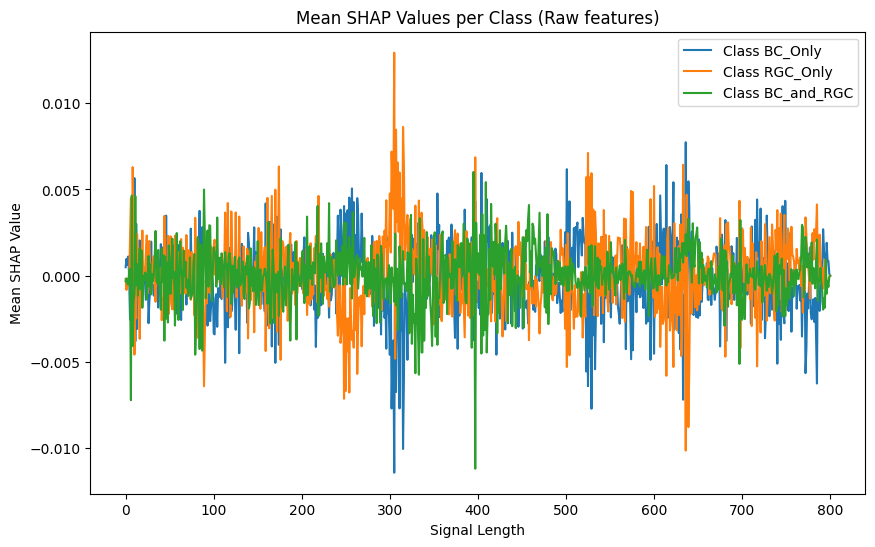

[[14 13 12]
 [ 6 27  6]
 [ 0  2 37]]


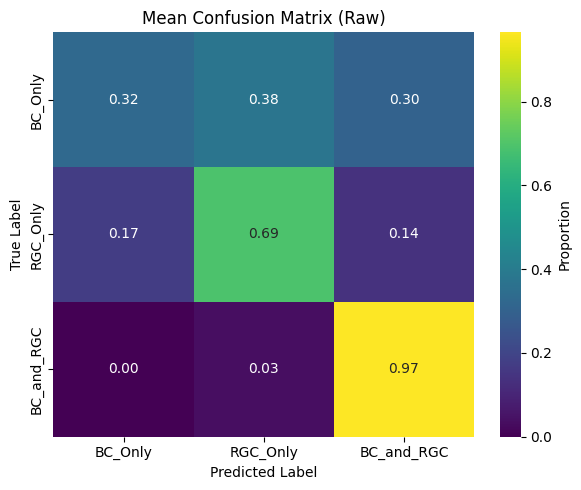


=== Processing Signal Type: DWT ===
--- Experiment 1 ---
Number of training samples: 117
Using batch size: 11
Using epochs: 35


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.4624 |     0.5833
    2 |     0.8817 |     0.7500
    3 |     0.9032 |     0.7917
    4 |     0.9570 |     0.7500
    5 |     0.9892 |     0.7083
    6 |     0.9785 |     0.7083
    7 |     1.0000 |     0.6667
    8 |     1.0000 |     0.6667
    9 |     1.0000 |     0.6667
   10 |     1.0000 |     0.6667
   11 |     0.9892 |     0.6250
   12 |     1.0000 |     0.6250
   13 |     1.0000 |     0.6250
   14 |     1.0000 |     0.6250
   15 |     1.0000 |     0.6250
   16 |     0.9892 |     0.6250
   17 |     1.0000 |     0.6250
   18 |     1.0000 |     0.6667
   19 |     1.0000 |     0.6667
   20 |     1.0000 |     0.6667
   21 |     1.0000 |     0.6667
   22 |     1.0000 |     0.6667
   23 |     1.0000 |     0.6667
   24 |     1.0000 |     0.7083
   25 |     1.0000 |     0.7083
   26 |     1.0000 |     0.7083
   27 |     1.0000 |     0.7083
   28 |     1.0000 |     0.7083
   29 |     1.0000 |     0.7083
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_165
Received: inputs=['Tensor(shape=(93, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_165
Received: inputs=['Tensor(shape=(186, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.4839 |     0.4583
    2 |     0.7742 |     0.4583
    3 |     0.9140 |     0.5833
    4 |     0.9462 |     0.5833
    5 |     1.0000 |     0.6250
    6 |     1.0000 |     0.7083
    7 |     0.9892 |     0.7083
    8 |     1.0000 |     0.7500
    9 |     0.9892 |     0.7500
   10 |     0.9785 |     0.7500
   11 |     0.9785 |     0.7500
   12 |     0.9892 |     0.7500
   13 |     1.0000 |     0.7500
   14 |     1.0000 |     0.7500
   15 |     1.0000 |     0.7500
   16 |     0.9892 |     0.7500
   17 |     0.9892 |     0.7500
   18 |     1.0000 |     0.7500
   19 |     1.0000 |     0.7500
   20 |     1.0000 |     0.7500
   21 |     1.0000 |     0.7500
   22 |     1.0000 |     0.7500
   23 |     1.0000 |     0.7917
   24 |     1.0000 |     0.7917
   25 |     1.0000 |     0.7917
   26 |     1.0000 |     0.7917
   27 |     1.0000 |     0.7917
   28 |     1.0000 |     0.7917
   29 |     1.0000 |     0.7917
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_176
Received: inputs=['Tensor(shape=(93, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_176
Received: inputs=['Tensor(shape=(186, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5319 |     0.4783
    2 |     0.8723 |     0.6087
    3 |     0.8936 |     0.6087
    4 |     0.9149 |     0.6522
    5 |     0.9574 |     0.6087
    6 |     0.9787 |     0.6957
    7 |     1.0000 |     0.6957
    8 |     1.0000 |     0.7391
    9 |     1.0000 |     0.7826
   10 |     1.0000 |     0.7826
   11 |     1.0000 |     0.6957
   12 |     1.0000 |     0.6522
   13 |     1.0000 |     0.7391
   14 |     1.0000 |     0.7826
   15 |     1.0000 |     0.6957
   16 |     0.9894 |     0.6957
   17 |     0.9894 |     0.6522
   18 |     1.0000 |     0.6522
   19 |     1.0000 |     0.6522
   20 |     1.0000 |     0.6522
   21 |     1.0000 |     0.6522
   22 |     1.0000 |     0.6522
   23 |     1.0000 |     0.6957
   24 |     1.0000 |     0.6957
   25 |     1.0000 |     0.6957
   26 |     1.0000 |     0.6957
   27 |     1.0000 |     0.6522
   28 |     1.0000 |     0.6522
   29 |     1.0000 |     0.6522
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_187
Received: inputs=['Tensor(shape=(94, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_187
Received: inputs=['Tensor(shape=(188, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.4043 |     0.6087
    2 |     0.8404 |     0.6957
    3 |     0.8830 |     0.6957
    4 |     0.9468 |     0.6522
    5 |     1.0000 |     0.6522
    6 |     0.9894 |     0.6522
    7 |     1.0000 |     0.6522
    8 |     0.9787 |     0.6087
    9 |     1.0000 |     0.5652
   10 |     1.0000 |     0.6087
   11 |     1.0000 |     0.6087
   12 |     1.0000 |     0.6087
   13 |     1.0000 |     0.6087
   14 |     1.0000 |     0.6087
   15 |     1.0000 |     0.6087
   16 |     1.0000 |     0.6087
   17 |     1.0000 |     0.6087
   18 |     1.0000 |     0.6087
   19 |     1.0000 |     0.6087
   20 |     1.0000 |     0.6087
   21 |     1.0000 |     0.6087
   22 |     1.0000 |     0.6087
   23 |     1.0000 |     0.6087
   24 |     1.0000 |     0.6087
   25 |     1.0000 |     0.6087
   26 |     1.0000 |     0.6087
   27 |     1.0000 |     0.6087
   28 |     1.0000 |     0.6522
   29 |     1.0000 |     0.6522
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_198
Received: inputs=['Tensor(shape=(94, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_198
Received: inputs=['Tensor(shape=(188, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5851 |     0.3913
    2 |     0.8830 |     0.5652
    3 |     0.9362 |     0.6087
    4 |     0.9787 |     0.6957
    5 |     0.9787 |     0.6957
    6 |     1.0000 |     0.6957
    7 |     1.0000 |     0.6522
    8 |     0.9894 |     0.6522
    9 |     1.0000 |     0.6522
   10 |     0.9894 |     0.6522
   11 |     1.0000 |     0.6522
   12 |     1.0000 |     0.6087
   13 |     1.0000 |     0.6087
   14 |     1.0000 |     0.6087
   15 |     1.0000 |     0.6087
   16 |     1.0000 |     0.6087
   17 |     1.0000 |     0.6087
   18 |     1.0000 |     0.6087
   19 |     1.0000 |     0.6087
   20 |     1.0000 |     0.6087
   21 |     1.0000 |     0.6087
   22 |     1.0000 |     0.6087
   23 |     1.0000 |     0.6522
   24 |     1.0000 |     0.6522
   25 |     1.0000 |     0.6957
   26 |     1.0000 |     0.6957
   27 |     1.0000 |     0.6957
   28 |     1.0000 |     0.7391
   29 |     1.0000 |     0.7391
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_209
Received: inputs=['Tensor(shape=(94, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_209
Received: inputs=['Tensor(shape=(188, 100, 1))']
  warnings.warn(msg)


shap_results_shapes: (23, 100, 1, 3)
mean_shap shape: (100,)
mean_shap shape: (100,)
mean_shap shape: (100,)


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_209
Received: inputs=['Tensor(shape=(23, 100, 1))']
  warnings.warn(msg)


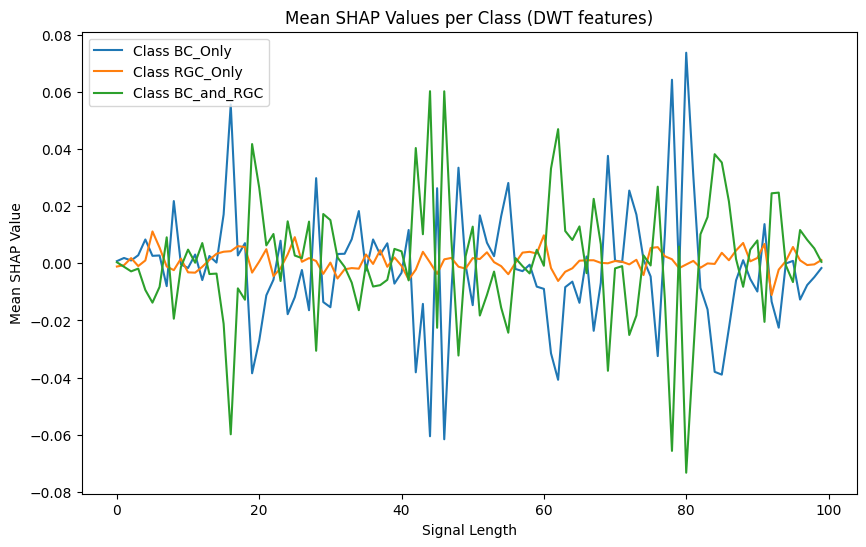

[[16 20  3]
 [ 8 29  2]
 [ 0  0 39]]
--- Experiment 2 ---
Number of training samples: 117
Using batch size: 11
Using epochs: 35


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5699 |     0.5000
    2 |     0.8602 |     0.6250
    3 |     0.8817 |     0.7083
    4 |     0.9032 |     0.7500
    5 |     0.9785 |     0.7500
    6 |     0.9785 |     0.7500
    7 |     0.9892 |     0.7500
    8 |     1.0000 |     0.7500
    9 |     0.9892 |     0.7500
   10 |     0.9892 |     0.7500
   11 |     1.0000 |     0.7500
   12 |     1.0000 |     0.7500
   13 |     0.9892 |     0.7500
   14 |     1.0000 |     0.7917
   15 |     1.0000 |     0.7917
   16 |     1.0000 |     0.7917
   17 |     1.0000 |     0.7917
   18 |     1.0000 |     0.7917
   19 |     1.0000 |     0.7917
   20 |     1.0000 |     0.7917
   21 |     0.9892 |     0.7917
   22 |     0.9892 |     0.7500
   23 |     1.0000 |     0.7500
   24 |     1.0000 |     0.7500
   25 |     1.0000 |     0.7500
   26 |     1.0000 |     0.7500
   27 |     1.0000 |     0.7500
   28 |     1.0000 |     0.7500
   29 |     1.0000 |     0.7500
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_220
Received: inputs=['Tensor(shape=(93, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_220
Received: inputs=['Tensor(shape=(186, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.4839 |     0.5417
    2 |     0.8495 |     0.5000
    3 |     0.9677 |     0.5833
    4 |     0.9462 |     0.5417
    5 |     0.9570 |     0.7083
    6 |     0.9892 |     0.7500
    7 |     0.9892 |     0.6667
    8 |     0.9785 |     0.6667
    9 |     0.9892 |     0.7083
   10 |     0.9785 |     0.7083
   11 |     1.0000 |     0.6667
   12 |     1.0000 |     0.6667
   13 |     0.9892 |     0.6667
   14 |     1.0000 |     0.6667
   15 |     1.0000 |     0.7083
   16 |     1.0000 |     0.7083
   17 |     1.0000 |     0.7083
   18 |     1.0000 |     0.7083
   19 |     1.0000 |     0.7083
   20 |     1.0000 |     0.7083
   21 |     1.0000 |     0.7083
   22 |     1.0000 |     0.7083
   23 |     1.0000 |     0.7083
   24 |     1.0000 |     0.7083
   25 |     1.0000 |     0.7083
   26 |     0.9892 |     0.7500
   27 |     1.0000 |     0.7500
   28 |     1.0000 |     0.7083
   29 |     1.0000 |     0.7083
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_231
Received: inputs=['Tensor(shape=(93, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_231
Received: inputs=['Tensor(shape=(186, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5851 |     0.4348
    2 |     0.8191 |     0.5217
    3 |     0.8830 |     0.5652
    4 |     0.9574 |     0.6522
    5 |     0.9787 |     0.6957
    6 |     0.9894 |     0.6957
    7 |     1.0000 |     0.6957
    8 |     1.0000 |     0.6087
    9 |     0.9894 |     0.6087
   10 |     1.0000 |     0.6087
   11 |     1.0000 |     0.6522
   12 |     0.9894 |     0.6087
   13 |     1.0000 |     0.6087
   14 |     1.0000 |     0.6522
   15 |     1.0000 |     0.6522
   16 |     1.0000 |     0.6522
   17 |     1.0000 |     0.6957
   18 |     1.0000 |     0.6957
   19 |     1.0000 |     0.6957
   20 |     1.0000 |     0.6957
   21 |     1.0000 |     0.6957
   22 |     1.0000 |     0.6957
   23 |     1.0000 |     0.6957
   24 |     1.0000 |     0.6957
   25 |     1.0000 |     0.6957
   26 |     1.0000 |     0.6957
   27 |     1.0000 |     0.6522
   28 |     1.0000 |     0.6957
   29 |     1.0000 |     0.6522
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_242
Received: inputs=['Tensor(shape=(94, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_242
Received: inputs=['Tensor(shape=(188, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5213 |     0.5652
    2 |     0.7979 |     0.4783
    3 |     0.9149 |     0.7391
    4 |     0.9681 |     0.6957
    5 |     0.9574 |     0.7391
    6 |     0.9574 |     0.6957
    7 |     0.9787 |     0.6957
    8 |     1.0000 |     0.6957
    9 |     0.9894 |     0.7391
   10 |     1.0000 |     0.6957
   11 |     0.9787 |     0.6522
   12 |     1.0000 |     0.6522
   13 |     1.0000 |     0.6522
   14 |     1.0000 |     0.6522
   15 |     1.0000 |     0.6522
   16 |     1.0000 |     0.6522
   17 |     1.0000 |     0.6522
   18 |     1.0000 |     0.6522
   19 |     1.0000 |     0.6522
   20 |     0.9894 |     0.6522
   21 |     1.0000 |     0.6522
   22 |     1.0000 |     0.6522
   23 |     1.0000 |     0.6522
   24 |     0.9894 |     0.6522
   25 |     1.0000 |     0.6522
   26 |     1.0000 |     0.6522
   27 |     1.0000 |     0.6957
   28 |     1.0000 |     0.6957
   29 |     1.0000 |     0.6957
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_253
Received: inputs=['Tensor(shape=(94, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_253
Received: inputs=['Tensor(shape=(188, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.4681 |     0.3478
    2 |     0.7766 |     0.6957
    3 |     0.9149 |     0.7391
    4 |     0.9043 |     0.7391
    5 |     0.9894 |     0.6957
    6 |     0.9894 |     0.6957
    7 |     1.0000 |     0.6522
    8 |     0.9894 |     0.6522
    9 |     1.0000 |     0.6522
   10 |     1.0000 |     0.6522
   11 |     1.0000 |     0.6522
   12 |     1.0000 |     0.6522
   13 |     0.9894 |     0.6522
   14 |     1.0000 |     0.6522
   15 |     0.9894 |     0.6522
   16 |     0.9894 |     0.6522
   17 |     1.0000 |     0.6522
   18 |     1.0000 |     0.6522
   19 |     1.0000 |     0.6522
   20 |     1.0000 |     0.6957
   21 |     1.0000 |     0.6957
   22 |     1.0000 |     0.6957
   23 |     0.9894 |     0.6957
   24 |     1.0000 |     0.6522
   25 |     1.0000 |     0.6522
   26 |     1.0000 |     0.6522
   27 |     1.0000 |     0.6522
   28 |     1.0000 |     0.6522
   29 |     1.0000 |     0.6522
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_264
Received: inputs=['Tensor(shape=(94, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_264
Received: inputs=['Tensor(shape=(188, 100, 1))']
  warnings.warn(msg)


shap_results_shapes: (23, 100, 1, 3)
mean_shap shape: (100,)
mean_shap shape: (100,)
mean_shap shape: (100,)


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_264
Received: inputs=['Tensor(shape=(23, 100, 1))']
  warnings.warn(msg)


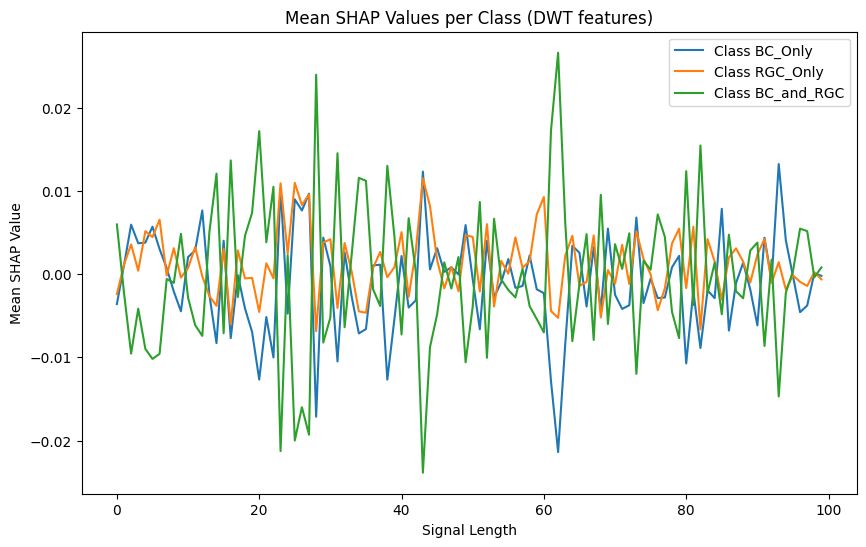

[[21 14  4]
 [12 24  3]
 [ 0  0 39]]
--- Experiment 3 ---
Number of training samples: 117
Using batch size: 11
Using epochs: 35


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5914 |     0.4167
    2 |     0.7742 |     0.8333
    3 |     0.8387 |     0.7500
    4 |     0.9462 |     0.7500
    5 |     0.9462 |     0.7917
    6 |     0.9785 |     0.7917
    7 |     1.0000 |     0.8333
    8 |     0.9785 |     0.8333
    9 |     1.0000 |     0.8333
   10 |     1.0000 |     0.7917
   11 |     1.0000 |     0.7917
   12 |     0.9892 |     0.7917
   13 |     1.0000 |     0.7917
   14 |     1.0000 |     0.7917
   15 |     1.0000 |     0.7917
   16 |     1.0000 |     0.7917
   17 |     1.0000 |     0.7917
   18 |     1.0000 |     0.7917
   19 |     0.9892 |     0.7500
   20 |     1.0000 |     0.7917
   21 |     0.9892 |     0.7917
   22 |     1.0000 |     0.7917
   23 |     1.0000 |     0.7917
   24 |     1.0000 |     0.7917
   25 |     1.0000 |     0.7917
   26 |     1.0000 |     0.7917
   27 |     1.0000 |     0.7917
   28 |     1.0000 |     0.7917
   29 |     1.0000 |     0.7917
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_275
Received: inputs=['Tensor(shape=(93, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_275
Received: inputs=['Tensor(shape=(186, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5376 |     0.4583
    2 |     0.8280 |     0.5833
    3 |     0.9462 |     0.6250
    4 |     0.9785 |     0.7083
    5 |     0.9677 |     0.7083
    6 |     0.9892 |     0.7917
    7 |     0.9892 |     0.8333
    8 |     1.0000 |     0.8333
    9 |     1.0000 |     0.7917
   10 |     0.9892 |     0.7500
   11 |     1.0000 |     0.7917
   12 |     1.0000 |     0.7917
   13 |     1.0000 |     0.7917
   14 |     1.0000 |     0.7917
   15 |     0.9892 |     0.7500
   16 |     1.0000 |     0.7500
   17 |     1.0000 |     0.7083
   18 |     1.0000 |     0.7500
   19 |     0.9892 |     0.8333
   20 |     0.9892 |     0.8333
   21 |     1.0000 |     0.8750
   22 |     1.0000 |     0.8750
   23 |     1.0000 |     0.8750
   24 |     1.0000 |     0.8750
   25 |     1.0000 |     0.8750
   26 |     1.0000 |     0.8750
   27 |     1.0000 |     0.8750
   28 |     1.0000 |     0.8750
   29 |     1.0000 |     0.8750
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_286
Received: inputs=['Tensor(shape=(93, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_286
Received: inputs=['Tensor(shape=(186, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5426 |     0.4783
    2 |     0.8830 |     0.4348
    3 |     0.9043 |     0.5217
    4 |     0.9149 |     0.6087
    5 |     0.9255 |     0.6522
    6 |     0.9362 |     0.6957
    7 |     0.9787 |     0.6957
    8 |     0.9894 |     0.6522
    9 |     0.9894 |     0.6522
   10 |     1.0000 |     0.6087
   11 |     1.0000 |     0.6087
   12 |     1.0000 |     0.6087
   13 |     0.9894 |     0.6087
   14 |     1.0000 |     0.6087
   15 |     1.0000 |     0.6087
   16 |     0.9894 |     0.6087
   17 |     1.0000 |     0.6087
   18 |     1.0000 |     0.6087
   19 |     1.0000 |     0.6087
   20 |     1.0000 |     0.6087
   21 |     1.0000 |     0.6087
   22 |     1.0000 |     0.6087
   23 |     1.0000 |     0.6087
   24 |     1.0000 |     0.6087
   25 |     1.0000 |     0.6087
   26 |     1.0000 |     0.6087
   27 |     1.0000 |     0.6087
   28 |     1.0000 |     0.6087
   29 |     1.0000 |     0.6087
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_297
Received: inputs=['Tensor(shape=(94, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_297
Received: inputs=['Tensor(shape=(188, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.6170 |     0.4348
    2 |     0.8191 |     0.6522
    3 |     0.9149 |     0.7826
    4 |     0.9468 |     0.7826
    5 |     0.9574 |     0.7826
    6 |     0.9681 |     0.7826
    7 |     1.0000 |     0.7391
    8 |     1.0000 |     0.6957
    9 |     0.9894 |     0.6957
   10 |     1.0000 |     0.6957
   11 |     1.0000 |     0.6957
   12 |     1.0000 |     0.6957
   13 |     1.0000 |     0.6957
   14 |     0.9894 |     0.6957
   15 |     0.9894 |     0.6957
   16 |     1.0000 |     0.7391
   17 |     1.0000 |     0.6957
   18 |     1.0000 |     0.6957
   19 |     1.0000 |     0.6957
   20 |     1.0000 |     0.6957
   21 |     1.0000 |     0.6957
   22 |     1.0000 |     0.6522
   23 |     1.0000 |     0.6957
   24 |     1.0000 |     0.7391
   25 |     1.0000 |     0.6957
   26 |     1.0000 |     0.7391
   27 |     1.0000 |     0.7391
   28 |     1.0000 |     0.7391
   29 |     1.0000 |     0.7391
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_308
Received: inputs=['Tensor(shape=(94, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_308
Received: inputs=['Tensor(shape=(188, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classi

Epoch |  Train Acc |    Val Acc
---------------------------------
    1 |     0.5426 |     0.5652
    2 |     0.7979 |     0.6087
    3 |     0.9255 |     0.6522
    4 |     0.9894 |     0.7391
    5 |     0.9787 |     0.7391
    6 |     0.9468 |     0.8261
    7 |     0.9787 |     0.7391
    8 |     0.9894 |     0.7391
    9 |     0.9894 |     0.7826
   10 |     1.0000 |     0.7826
   11 |     1.0000 |     0.7826
   12 |     1.0000 |     0.7826
   13 |     1.0000 |     0.7826
   14 |     1.0000 |     0.7826
   15 |     1.0000 |     0.7826
   16 |     1.0000 |     0.7826
   17 |     1.0000 |     0.7826
   18 |     1.0000 |     0.7826
   19 |     1.0000 |     0.7826
   20 |     1.0000 |     0.7826
   21 |     1.0000 |     0.7826
   22 |     1.0000 |     0.7391
   23 |     0.9894 |     0.7826
   24 |     1.0000 |     0.7826
   25 |     1.0000 |     0.8261
   26 |     1.0000 |     0.8261
   27 |     1.0000 |     0.7826
   28 |     1.0000 |     0.7826
   29 |     1.0000 |     0.7826
   30 

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_319
Received: inputs=['Tensor(shape=(94, 100, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_319
Received: inputs=['Tensor(shape=(188, 100, 1))']
  warnings.warn(msg)


shap_results_shapes: (23, 100, 1, 3)
mean_shap shape: (100,)
mean_shap shape: (100,)
mean_shap shape: (100,)


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_319
Received: inputs=['Tensor(shape=(23, 100, 1))']
  warnings.warn(msg)


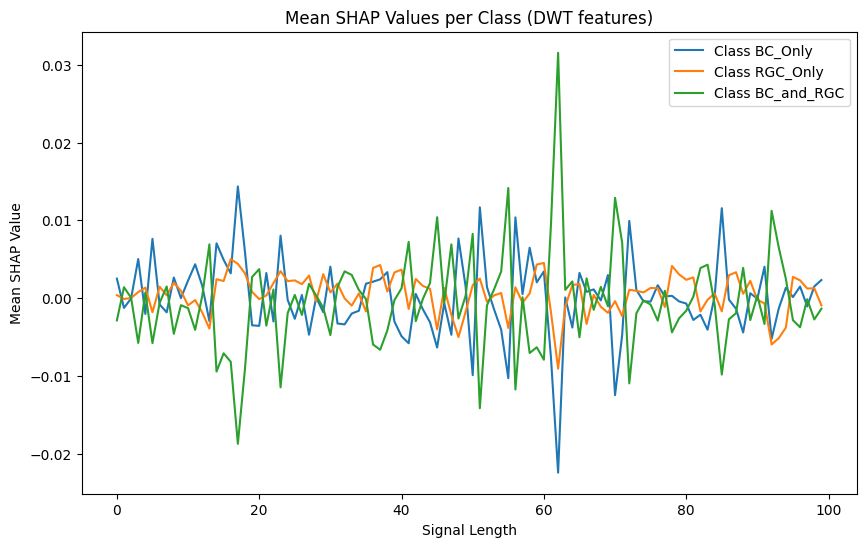

[[25 11  3]
 [11 26  2]
 [ 0  0 39]]


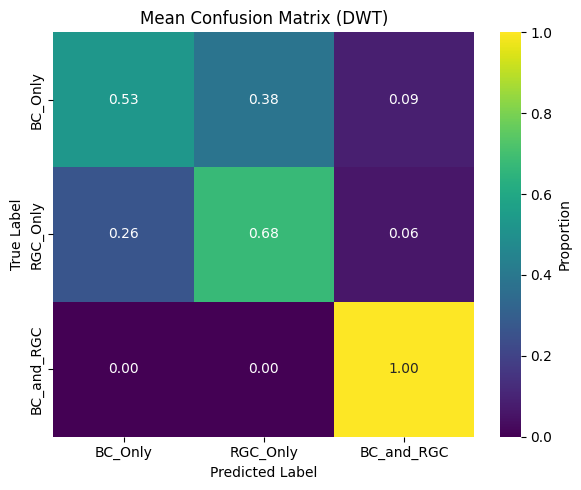

In [6]:
average_results = {}

signal_types = ["Raw", "DWT"]

for signal_type in signal_types:
    print(f"\n=== Processing Signal Type: {signal_type} ===")
    results = []
    all_conf_matrices = []
    for experiments in range(3):
        print(f"--- Experiment {experiments + 1} ---")
        np.random.seed(42)
        no_files = min(len(prima_files_BC_only), len(prima_files_RGC_only), len(prima_files_BC_and_RGC))
        sampled_BC = np.random.choice(prima_files_BC_only, no_files, replace=False)
        sampled_RGC = np.random.choice(prima_files_RGC_only, no_files, replace=False)
        sampled_BC_and_RGC = np.random.choice(prima_files_BC_and_RGC, no_files, replace=False)

        X, labels = [], []
        for file in sampled_BC:
            _, signal = process_file(file, t_max=200)
            if signal_type == "Raw":
                X.append(signal)
            else:
                X.append(FeatureExtractor.extract_dwt_features(signal, wavelet='db4', level=4))
            labels.append("BC_Only")
        for file in sampled_RGC:
            _, signal = process_file(file, t_max=200)
            if signal_type == "Raw":
                X.append(signal)
            else:
                X.append(FeatureExtractor.extract_dwt_features(signal, wavelet='db4', level=4))
            labels.append("RGC_Only")
        for file in sampled_BC_and_RGC:
            _, signal = process_file(file, t_max=200)
            if signal_type == "Raw":
                X.append(signal)
            else:
                X.append(FeatureExtractor.extract_dwt_features(signal, wavelet='db4', level=4))
            labels.append("BC_and_RGC")

        n_train = len(X)
        print(f"Number of training samples: {n_train}")
        # batch_size = 4
        # epochs = 30
        batch_size = max(4, min(32, n_train // 10))

        print(f"Using batch size: {batch_size}")
        if n_train < 100:
            epochs = 50
        elif n_train < 500:
            epochs = 35
        else:
            epochs = 20
        print(f"Using epochs: {epochs}")

        clf = CNN1D(X, labels, model_type="cnn", n_splits=5, random_state=42)
        y_true, y_pred, shap_values = clf.fit(epochs=epochs, batch_size=batch_size)
        print("shap_results_shapes:", shap_values.shape) # (17, 761, 1, 3) = (n_samples, signal_length, 1, n_classes)
        plt.figure(figsize=(10, 6))
        for c in range(shap_values.shape[-1]):
            mean_shap = np.mean(shap_values[:, :, 0, c], axis=0)  # Mean SHAP values for class c
            print("mean_shap shape:", mean_shap.shape)  # (signal_length,)
            plt.plot(mean_shap, label=f"Class {unique_labels[c]}")
        plt.title(f"Mean SHAP Values per Class ({signal_type} features)")
        plt.xlabel("Signal Length")
        plt.ylabel("Mean SHAP Value")
        plt.legend()
        plt.show()
        metrics = clf.evaluate(y_true, y_pred)

        results.append({
                "Accuracy": metrics["accuracy"],
                "BalancedAcc": metrics["balanced_accuracy"],
                "F1": metrics["f1_score"],
                "Acc BC_Only": metrics["report"]["BC_Only"]["recall"],
                "Acc RGC_and_BC": metrics["report"]["BC_and_RGC"]["recall"],
                "Acc RGC_Only": metrics["report"]["RGC_Only"]["recall"],
            })
        all_conf_matrices.append(
            confusion_matrix(
                y_true, y_pred, labels=["BC_Only", "RGC_Only", "BC_and_RGC"]
            )
        )

    accs = [r["Accuracy"] for r in results]
    balanced_accs = [r["BalancedAcc"] for r in results]
    f1s = [r["F1"] for r in results]
    bc_accs = [float(r["Acc BC_Only"]) for r in results]
    rgc_accs = [float(r["Acc RGC_Only"]) for r in results]
    bc_rgc_accs = [float(r["Acc RGC_and_BC"]) for r in results]

    average_results[(signal_type)] = {
        "Accuracy_mean": np.mean(accs),
        "Accuracy_std": np.std(accs),
        "BalancedAcc_mean": np.mean(balanced_accs),
        "BalancedAcc_std": np.std(balanced_accs),
        "F1_mean": np.mean(f1s),
        "F1_std": np.std(f1s),

        # per-class accuracies (recall)
        "Acc_BC_Only_mean": np.mean(bc_accs),
        "Acc_BC_Only_std": np.std(bc_accs),
        "Acc_RGC_Only_mean": np.mean(rgc_accs),
        "Acc_RGC_Only_std": np.std(rgc_accs),
        "Acc_BC_and_RGC_mean": np.mean(bc_rgc_accs),
        "Acc_BC_and_RGC_std": np.std(bc_rgc_accs),
    }
    mean_conf_matrix = np.mean(all_conf_matrices, axis=0)
    mean_conf_matrix = mean_conf_matrix / mean_conf_matrix.sum(axis=1, keepdims=True)

    labels = ["BC_Only", "RGC_Only", "BC_and_RGC"] 
    plt.figure(figsize=(6,5)) 
    sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", cmap="viridis", xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Proportion'}) 
    plt.title(f"Mean Confusion Matrix ({signal_type})") 
    plt.xlabel("Predicted Label") 
    plt.ylabel("True Label") 
    plt.tight_layout()
    plt.show()

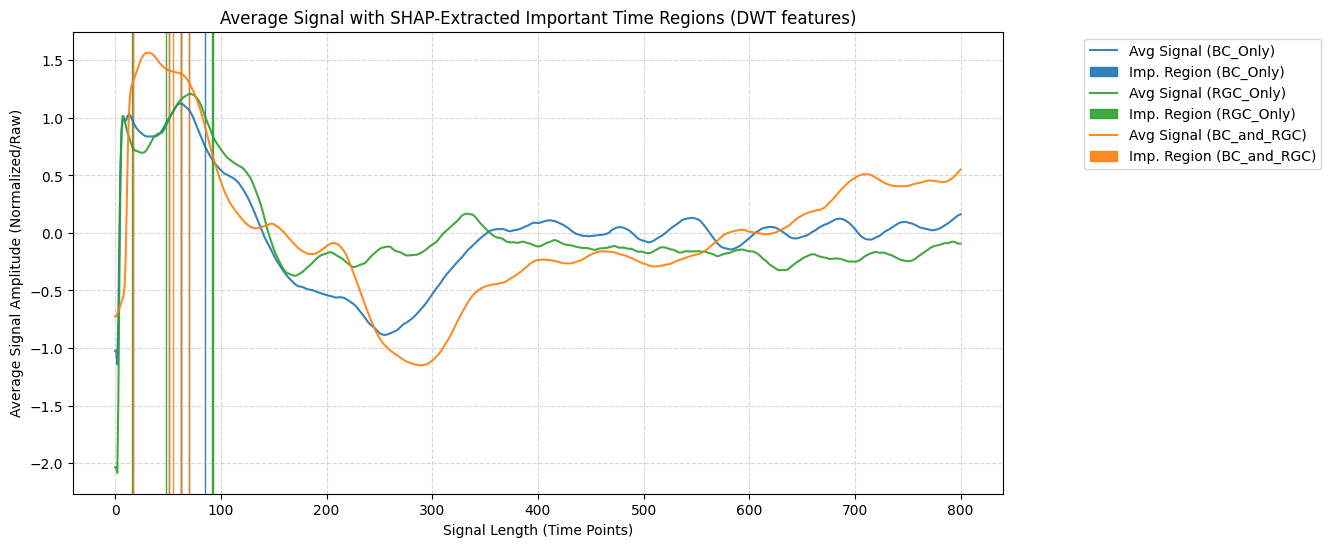

In [7]:
ABS_SHAP_THRESHOLD_PERCENTILE = 95
unique_labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]
label_colors = ['tab:blue', 'tab:green', 'tab:orange']

# Calculate the overall average signal for each class for visualization
mean_signals = {}
# append avg_BC_sig, avg_RGC_sig, avg_BC_RGC_sig to mean_signals
mean_signals["BC_Only"] = avg_BC_sig
mean_signals["RGC_Only"] = avg_RGC_sig
mean_signals["BC_and_RGC"] = avg_BC_RGC_sig

# Create a new figure for the visualization
plt.figure(figsize=(12, 6))

for c in range(shap_values.shape[-1]):
    class_label = unique_labels[c] 
    mean_shap = np.mean(shap_values[:, :, 0, c], axis=0) 
    abs_mean_shap = np.abs(mean_shap)
    threshold = np.percentile(abs_mean_shap, ABS_SHAP_THRESHOLD_PERCENTILE) 
    important_indices = np.where(abs_mean_shap >= threshold)[0]
    
    plt.plot(mean_signals[class_label], 
             label=f"Avg Signal ({class_label})", 
             color=label_colors[c], 
             alpha=0.9)
    
    # Group continuous indices (simplified grouping for demonstration)
    segments = []
    if important_indices.size > 0:
        start = important_indices[0]
        end = important_indices[0]
        for i in range(1, len(important_indices)):
            if important_indices[i] == important_indices[i-1] + 1:
                end = important_indices[i]
            else:
                segments.append((start, end))
                start = important_indices[i]
                end = important_indices[i]
        segments.append((start, end))
        
    for start, end in segments:
        # Highlight the segment 
        plt.axvspan(start, end, 
                    alpha=0.9, 
                    color=label_colors[c], 
                    label=f"Imp. Region ({class_label})" if start == segments[0][0] else None)

# Add descriptive plot elements
plt.title(f"Average Signal with SHAP-Extracted Important Time Regions ({signal_type} features)")
plt.xlabel("Signal Length (Time Points)")
plt.ylabel("Average Signal Amplitude (Normalized/Raw)")
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [8]:
summarize_results_and_save(average_results, model_name="1DCNN")


Top 10 setups by F1 Score:
Model Feature_Type F1 (mean ± std) BC_Only (mean ± std) RGC_Only (mean ± std) BC_and_RGC (mean ± std)
1DCNN          DWT   0,725 ± 0,028         0,53 ± 0,094         0,675 ± 0,053               1,0 ± 0,0
1DCNN          Raw   0,632 ± 0,008        0,325 ± 0,032         0,692 ± 0,021           0,966 ± 0,012

Summary saved to: results/1DCNN_average_classification_results.csv
